# Feature Crosses

This notebook is the same algorithm as model_v1.ipynb, but uses feature crosses:
{X1X2, X1X3, X1X2}

In [ ]:
# Connect notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Navigate to the shared drive folder
%cd /content/drive/'My Drive'/'Pig Proteomics Summer Project'
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
'2021-06-21 Introduction to Proteomes.ipynb'
'2021-06-28 Reactome and Uniprot.ipynb'
'2021-06-29 Identifying characteristics of an unreliable protein.gslides'
 data
 gene_PE.ipynb
 histogram.ipynb
'machine learning.gslides'
 model_v1.ipynb
 model_v2.ipynb
 model_v3.ipynb
 output
 pe_scores.ipynb
 scratch
'Summer Project.gdoc'
 violin.ipynb
'Week 1 Introduction slides.gslides'
'Week 3 Findings.gslides'


In [ ]:
!pip install fastaparser

# **Feature Extraction**
The features of interest (so far):
1. Protein length
2. PE score
3. Number of confirmed isoforms
4. Number of computational isoforms

In [ ]:
import fastaparser
import pandas as pd

def parse_fasta_file(file_name):
  """
  this function parses a FASTA database and returns it as a mapping from the
  header of the protein to the amino acid sequence it corresponds to
  mapping: {header: sequence}
  """
  out_dict = {}
  fastaRaw = [] #uses quick parsing method
  with open(file_name) as fasta_file:
      parserQuick = fastaparser.Reader(fasta_file, parse_method = 'quick')
      
      for seq in parserQuick:
          fastaRaw.append(seq)
          
  headerList = []
  seqList = []

  for k in fastaRaw:
      headerList.append(k.header)
      seqList.append(k.sequence)

  if len(headerList) != len(seqList):
      raise ValueError("Number of headers =/= number of sequences")

  for i in range(len(headerList)):
      out_dict[headerList[i]] = seqList[i]

  return out_dict

def extract_protein_length(file_name):
  """
  gets protein length in the following format:
  {accession ID : protein length}
  """
  out_dict = parse_fasta_file(file_name)
  protein_to_length = {}

  for key in out_dict.keys():
    indice = []
    for k in range(len(key)):
      t = key[k]
      if '|' in t:
        indice.append(k)
    accession = key[indice[0] + 1 : indice[1]]

    protein_to_length[accession] = len(out_dict[key])


  return protein_to_length

def extract_PE_scores(file_name):
  """
  gets PE score in the following format:
  {accession ID : PE score}
  """
  out_dict = parse_fasta_file(file_name)
  protein_to_PE_score = {}

  for key in out_dict.keys():
    indice_accession = []
    indice_PE = []
    for i in range(len(key)):
      t_accession = key[i]
      if '|' in t_accession:
        indice_accession.append(i)    
    accession = key[indice_accession[0] + 1 : indice_accession[1]]

    for j in range(len(key)):
      t_pe = key[j:j+3]
      if 'PE=' in t_pe:
        indice_PE.append(j)
    
    pe_score = int(key[indice_PE[0] + 3 : indice_PE[0] + 4])
    protein_to_PE_score[accession] = pe_score
  
  return protein_to_PE_score

def extract_confirmed_isoforms(isoform_file):
  """
  {accession ID : num of confirmed isoforms}
  specifically takes isoform file
  """
  protein_to_length = extract_protein_length(isoform_file) #{accession ID : length of sequence}
  protein_to_isoform = {}

  set_of_proteins = list(set(protein_to_length.keys()))
  set_of_isoforms = [x for x in set_of_proteins if '-' in x] #list of isoforms
  set_of_no_isoforms = [x for x in set_of_proteins if '-' not in x] #list of non-isoforms

  for protein in set_of_no_isoforms:
    c = 0
    for k in set_of_isoforms:
      if protein in k:
        c = c + 1
    
    protein_to_isoform[protein] = c
  
  return protein_to_isoform

def reference_proteome(file_name, proteome_file):
  """
  returns 1 if protein is in reference proteome, 0 if protein is not in reference proteome
  file_name -> full db
  proteome_file -> proteome db
  """
  all_proteins = list(set(extract_protein_length(file_name).keys()))
  proteome_proteins = list(set(extract_protein_length(proteome_file).keys()))

  protein_to_binary = {}
  for protein in all_proteins:
    if protein in proteome_proteins:
      protein_to_binary[protein] = 1
    elif protein not in proteome_proteins:
      protein_to_binary[protein] = 0
  
  return protein_to_binary

# **Compiling Features into Dictionary**
format: {accession ID : [protein length, PE score, num of confirmed isoforms]}

In [ ]:
def protein_to_features(file_name, proteome_file, isoform_file):
  """
  inputs:
  file_name -> full protein db
  proteome_file -> reference proteome db
  isoform_file -> full protein db with isoforms
  creates dictionary in the following format:
  {accession ID : [protein length, PE score, num of confirmed isoforms]}
  """
  #hopefully the keys of each dictionary defined above are identical to each other
  protein_to_length = extract_protein_length(file_name)
  protein_to_PE_score = extract_PE_scores(file_name)
  protein_to_isoform = extract_confirmed_isoforms(isoform_file)
  protein_to_binary = reference_proteome(file_name, proteome_file)

  protein_to_features = {}

  for key in list(protein_to_length.keys()):
    protein_to_features[key] = [protein_to_length[key],
                                protein_to_PE_score[key],
                                protein_to_isoform[key],
                                protein_to_binary[key]]
  
  return protein_to_features

def protein_features_dataframe(protein_features_dict):
  """
  input: protein_to_features output
  output: dataframe; headers = ['Protein Accession ID', 'Length', 'PE Score', '#Isoforms (confirmed)', 'In reference proteome']
  """  
  accession = []
  length = []
  pe_score = []
  confirmed_isoforms = []
  ref_proteome = []

  for protein in list(protein_features_dict.keys()):
    accession.append(protein)
    length.append(protein_features_dict[protein][0])
    pe_score.append(protein_features_dict[protein][1])
    confirmed_isoforms.append(protein_features_dict[protein][2])
    ref_proteome.append(protein_features_dict[protein][3])
  
  d = {'Protein Accession' : accession,
       'Length' : length,
       'PE Score' : pe_score,
       '#Confirmed Isoforms' : confirmed_isoforms,
       'In Reference Proteome' : ref_proteome}

  return pd.DataFrame(data = d)

In [ ]:
%cd output/protein_features/

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output/protein_features


In [ ]:
df_protein_features = pd.read_csv("human_protein_features.csv")
df_protein_features = df_protein_features.drop(df_protein_features.columns[[0]], axis = 1)
df_protein_features

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome
0,P04439,365,1,1,1
1,P01911,266,1,0,1
2,P01889,362,1,0,1
3,P31689,397,1,1,1
4,P08246,267,1,0,1
...,...,...,...,...,...
202155,Q9P2T1,348,1,2,1
202156,Q8IUX8,553,1,1,1
202157,O15372,352,1,0,1
202158,P54852,163,1,0,1


In [ ]:
def feature_crosses(df_protein_features):
  """
  outputs dataframe but with the cross features
  cross features:
  1. length*PE
  2. length*n (n = confirmed isoforms)
  3. PE*n
  """
  length_PE = []
  length_n = []
  pe_n = []

  for k in range(len(df_protein_features['Length'])):
    length_PE.append(df_protein_features['Length'][k] * df_protein_features['PE Score'][k])
    length_n.append(df_protein_features['Length'][k] * df_protein_features['#Confirmed Isoforms'][k])
    pe_n.append(df_protein_features['Length'][k] * df_protein_features['#Confirmed Isoforms'][k])
  
  df_protein_features['Length * PE Score'] = length_PE
  df_protein_features['Length * #Confirmed Isoforms'] = length_n
  df_protein_features['PE Score * #Confirmed Isoforms'] = pe_n

  return df_protein_features

In [ ]:
df_protein_new = feature_crosses(df_protein_features)
df_protein_new

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
0,P04439,365,1,1,1,365,365,365
1,P01911,266,1,0,1,266,0,0
2,P01889,362,1,0,1,362,0,0
3,P31689,397,1,1,1,397,397,397
4,P08246,267,1,0,1,267,0,0
...,...,...,...,...,...,...,...,...
202155,Q9P2T1,348,1,2,1,348,696,696
202156,Q8IUX8,553,1,1,1,553,553,553
202157,O15372,352,1,0,1,352,0,0
202158,P54852,163,1,0,1,163,0,0


# **Training Model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from math import *

def initialize_weights_bias(num_features = 6):
  """
  initializes w and b
  output: np.array -> w
  output: int -> b (0)
  """
  weights = np.zeros((1,num_features))
  bias = 0

  return weights, bias

def sigmoid_function(z):
  """
  evaluates sigma(z) = 1/(1 + exp(-z))
  """
  return 1/(1 + np.exp(-z))

def model_construction(df_protein_features):
  inp_df = df_protein_features.drop(df_protein_features.columns[[0,4]], axis=1)
  out_df = df_protein_features.drop(df_protein_features.columns[[0,1,2,3,5,6,7]], axis=1)
  
  scaler = StandardScaler()
  inp_df = scaler.fit_transform(inp_df) #transforms into Z values

  X_train, X_test, Y_train, Y_test = train_test_split(inp_df, out_df, test_size=0.2, train_size = 0.8)

  return X_train, Y_train, X_test, Y_test

def evaluate_cost(w, b, X_train, Y_train):
  """
  J = -y*log(sigma(Z)) - (1-y)*log(sigma(Z))
  positive training set : y = 1 (ones in human reference proteome)
  negative training set : y = 0 (ones not in human reference proteome)
  """
  m = X_train.shape[0] #number of rows in X_train dataset (training set is entire human db)
  z = np.dot(w, X_train.T) + b
  a = sigmoid_function(z) #evaluates sigmoid function
  
  cost = (-1/m)*(np.array(Y_train.T*np.log(a) + (1 - Y_train.T)*np.log(1 - a))).sum()
  dJdw = (1/m)*(np.dot(X_train.T, (a-Y_train.T).T))
  dJdb = (1/m)*(np.array(a-Y_train.T).sum())

  return cost, dJdw, dJdb

def model_predict(w, b, df_protein_features, n = 4500, alpha = 0.001):
  """
  predicts model for constructing the reference proteome
  w -> initialized weights
  b -> initialized bias
  X_train -> X-axis of training set (all the features ; length, PE score, #isoforms (confirmed))
  Y_train -> Y-axis of training set (in reference proteome or no?)
  n -> number of iterations

  also creates cost function vs. iteration num
  """
  X_train, Y_train, X_test, Y_test = model_construction(df_protein_features)
  cost_train = []
  cost_test = []
  iteration_num = []
  for i in range(n):
    iteration_num.append(i)
    cost_tr, dJdw, dJdb = evaluate_cost(w, b, X_train, Y_train)
    cost_te, _ , _ = evaluate_cost(w, b, X_test, Y_test)
    cost_train.append(cost_tr)
    cost_test.append(cost_te)

    w = w - alpha*dJdw.T
    b = b - alpha*dJdb
  
  plt.plot(iteration_num, cost_train)
  plt.plot(iteration_num, cost_test)
  plt.legend(['Training set', 'Testing set'])
  plt.xlabel("Iteration number")
  plt.ylabel("Cost")

  return w, b


In [ ]:
df_protein_new.to_csv("feature_crosses.csv")

In [ ]:
w, b = initialize_weights_bias()
w

array([[0., 0., 0., 0., 0., 0.]])

array([[ 0.05886958, -0.33994867,  0.11822008, -0.09167097,  0.04450159,
         0.04450159]])

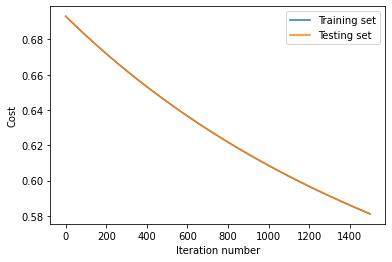

In [ ]:
w, b = model_predict(w, b, df_protein_features, n = 1500, alpha = 0.001)
w

In [ ]:
b

-0.14222154220415592

In [ ]:
w = np.array([[ 0.05886958, -0.33994867,  0.11822008, -0.09167097,  0.04450159,
         0.04450159]])

w = w[0]
w

array([ 0.05886958, -0.33994867,  0.11822008, -0.09167097,  0.04450159,
        0.04450159])

# **Testing Model**

In [ ]:
%cd -

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project


In [ ]:
from scipy.stats import zscore

def jaccard_overlap(predicted, reference):
  """
  computes jaccard overlap; J = A.intersection(B)/A.union(B)
  """
  return len(predicted.intersection(reference))/len(predicted.union(reference))


In [ ]:
def z_score_dataframe(all):
    """
    returns df w/ z-scores
    """
    #all
    all_input = all.drop(all.columns[[0,4]], axis=1) #[Length, PE Score, #Confirmed Isoforms, Length * PE Score, Length * #Confirmed Isoforms, PE Score * #Confirmed Isoforms]
    all_input = all_input.apply(zscore)
    all_proteins = list(all['Protein Accession'])
    all_binary = list(all['In Reference Proteome'])
    all_z_length = list(all_input['Length'])
    all_z_pe_score = list(all_input['PE Score'])
    all_z_isoforms = list(all_input['#Confirmed Isoforms'])
    all_z_w1w2 = list(all_input['Length * PE Score'])
    all_z_w1w3 = list(all_input['Length * #Confirmed Isoforms'])
    all_z_w2w3 = list(all_input['PE Score * #Confirmed Isoforms'])

    #creating all dataframe with z-scores
    all['Protein Accession'] = all_proteins
    all['Length'] = all_z_length
    all['PE Score'] = all_z_pe_score
    all['#Confirmed Isoforms'] = all_z_isoforms
    all['Length * PE Score'] = all_z_w1w2
    all['Length * #Confirmed Isoforms'] = all_z_w1w3
    all['PE Score * #Confirmed Isoforms'] = all_z_w2w3
    all['In Reference Proteome'] = all_binary

    return all

def jaccard_threshold_plot(all, reference, w, b):
    """
    plot jaccard overlap score vs. the threshold to be added to the reference proteome
    all -> all proteins df
    reference -> reference proteome df
    """
    p = np.linspace(0,1,1000)
    #w = w[0]

    #data processing
    #reference proteome
    reference_proteins = set(reference['accession'])

    #all
    all_input = all.drop(all.columns[[0,4]], axis=1) #[Length, PE Score, #Confirmed Isoforms]
    all_input = all_input.apply(zscore)
    all_proteins = list(all['Protein Accession'])
    all_binary = list(all['In Reference Proteome'])
    all_z_length = list(all_input['Length'])
    all_z_pe_score = list(all_input['PE Score'])
    all_z_isoforms = list(all_input['#Confirmed Isoforms'])

    #creating all dataframe with z-scores
    all['Protein Accession'] = all_proteins
    all['Length'] = all_z_length
    all['PE Score'] = all_z_pe_score
    all['#Confirmed Isoforms'] = all_z_isoforms
    all['In Reference Proteome'] = all_binary

    J = []

    for threshold in p:
        protein_above_threshold = []
        for k in range(len(all['Length'])):
            L = [all['Length'][k], all['PE Score'][k], all['#Confirmed Isoforms'][k],
                 all['Length * PE Score'][k], all['Length * #Confirmed Isoforms'][k],
                 all['PE Score * #Confirmed Isoforms'][k]]
            z = w[0]*L[0] + w[1]*L[1] + w[2]*L[2] + w[3]*L[3] + w[4]*L[4] + w[5]*L[5] + b
            sigma = sigmoid_function(z)

            if sigma >= threshold:
                protein_above_threshold.append(all['Protein Accession'][k])
            else:
                pass

        J_calc = jaccard_overlap(set(protein_above_threshold), reference_proteins)
        J.append(J_calc)
        
    plt.plot(p, J)

    #return all


In [ ]:
%cd output

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output


In [ ]:
human_proteome = pd.read_csv("human_proteome_table_PE.csv")
human_proteome = human_proteome.drop(columns=['Unnamed: 0'], axis = 1)
human_proteome

,sptr,accession,organism,Gene Name,length,PE Score
0,sp,Q00266,Homo sapiens,MAT1A,395,1
1,sp,Q8NB16,Homo sapiens,MLKL,471,1
2,sp,O94851,Homo sapiens,MICAL2,1124,1
3,sp,Q8TDZ2,Homo sapiens,MICAL1,1067,1
4,sp,Q9NPJ6,Homo sapiens,MED4,270,1
...,...,...,...,...,...,...
78115,tr,A0A087WVB8,Homo sapiens,CNBD2,181,1
78116,tr,H0Y876,Homo sapiens,CCDC136,548,1
78117,tr,A0A3B3IU88,Homo sapiens,No Name,217,4
78118,tr,A0A1W2PR38,Homo sapiens,CSAG2,78,4


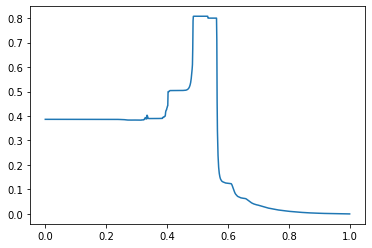

In [ ]:
jaccard_threshold_plot(df_protein_new, human_proteome, w, b)

In [ ]:
sample_size = int(0.2*len(df_protein_new['Length']))
sample_df = df_protein_features.sample(sample_size)
sample_df

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
34273,A0A0C4DGU7,0.046370,-1.171799,-0.172949,1,-0.354992,-0.070546,-0.070546
172175,P03956,0.432424,-1.171799,-0.172949,1,-0.170573,-0.070546,-0.070546
104929,E5RI37,-0.412857,1.528787,-0.172949,1,-0.089814,-0.070546,-0.070546
105840,B4DKE2,0.217950,-0.271604,-0.172949,0,0.189828,-0.070546,-0.070546
168040,A0A1B0GVQ3,-0.327068,1.528787,-0.172949,1,0.074114,-0.070546,-0.070546
...,...,...,...,...,...,...,...,...
121733,A0A0J9YXP0,0.651945,-1.171799,-0.172949,1,-0.065707,-0.070546,-0.070546
158130,S5DN29,-0.062129,0.628592,-0.172949,0,0.251302,-0.070546,-0.070546
131140,F4YU78,-0.294266,0.628592,-0.172949,0,-0.081377,-0.070546,-0.070546
57837,R4L8Y9,-0.294266,0.628592,-0.172949,0,-0.081377,-0.070546,-0.070546


In [ ]:
sample_df = z_score_dataframe(sample_df)
sample_df

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
34273,A0A0C4DGU7,0.054415,-1.178345,-0.168989,1,-0.407115,-0.12478,-0.12478
172175,P03956,0.485866,-1.178345,-0.168989,1,-0.195806,-0.12478,-0.12478
104929,E5RI37,-0.458814,1.524335,-0.168989,1,-0.103273,-0.12478,-0.12478
105840,B4DKE2,0.246171,-0.277452,-0.168989,0,0.217143,-0.12478,-0.12478
168040,A0A1B0GVQ3,-0.362936,1.524335,-0.168989,1,0.084557,-0.12478,-0.12478
...,...,...,...,...,...,...,...,...
121733,A0A0J9YXP0,0.731201,-1.178345,-0.168989,1,-0.075651,-0.12478,-0.12478
158130,S5DN29,-0.066842,0.623442,-0.168989,0,0.287579,-0.12478,-0.12478
131140,F4YU78,-0.326277,0.623442,-0.168989,0,-0.093605,-0.12478,-0.12478
57837,R4L8Y9,-0.326277,0.623442,-0.168989,0,-0.093605,-0.12478,-0.12478


In [ ]:
reference_proteins = []

for k in range(len(sample_df['Length'])):
    if sample_df['In Reference Proteome'].values[k] == 1:
        reference_proteins.append(sample_df['Protein Accession'].values[k])
    else:
        pass

reference_proteins = set(reference_proteins)
reference_proteins

In [ ]:
threshold = 0.5 #change depending on plot of J vs. threshold (p)
#w = w[0]
proteins_predict = []

for k in range(len(sample_df['Length'])):
    L = [list(sample_df['Length'])[k],
         list(sample_df['PE Score'])[k],
         list(sample_df['#Confirmed Isoforms'])[k],
         list(sample_df['Length * PE Score'])[k],
         list(sample_df['Length * #Confirmed Isoforms'])[k],
         list(sample_df['PE Score * #Confirmed Isoforms'])[k]]
    
    z = w[0]*L[0] + w[1]*L[1] + w[2]*L[2] + w[3]*L[3] + w[4]*L[4] + w[5]*L[5] + b
    p = sigmoid_function(z)

    if p >= threshold:
        proteins_predict.append(list(sample_df['Protein Accession'])[k])

J = jaccard_overlap(set(proteins_predict), set(reference_proteins))
J

0.8053909386350602

# **Testing on Mouse**

In [ ]:
%cd -

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project


In [ ]:
%cd data

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/data


In [ ]:
mouse_all_file = 'mus_musculus_all.fasta'
mouse_proteome_file = 'mus_musculus_uniprot-proteome_UP000000589.fasta'
mouse_isoform_file = 'all_mouse_and_isoforms.fasta'

In [ ]:
protein_to_features_mouse = protein_to_features(mouse_all_file, mouse_proteome_file, mouse_isoform_file)
protein_to_features_mouse_df = protein_features_dataframe(protein_to_features_mouse)
protein_to_features_mouse_df

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome
0,P02762,180,1,0,1
1,Q91ZJ0,551,1,0,1
2,Q6ZQL8,611,2,0,0
3,Q8R4K8,1624,2,1,1
4,P02089,147,1,0,1
...,...,...,...,...,...
86516,Q9Z0F1,257,2,1,1
86517,Q9DCZ1,345,1,0,1
86518,Q9EQQ3,425,2,0,1
86519,Q99L27,348,1,0,1


In [ ]:
protein_features_mouse = feature_crosses(protein_to_features_mouse_df)
protein_features_mouse

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
0,P02762,180,1,0,1,180,0,0
1,Q91ZJ0,551,1,0,1,551,0,0
2,Q6ZQL8,611,2,0,0,1222,0,0
3,Q8R4K8,1624,2,1,1,3248,1624,1624
4,P02089,147,1,0,1,147,0,0
...,...,...,...,...,...,...,...,...
86516,Q9Z0F1,257,2,1,1,514,257,257
86517,Q9DCZ1,345,1,0,1,345,0,0
86518,Q9EQQ3,425,2,0,1,850,0,0
86519,Q99L27,348,1,0,1,348,0,0


In [ ]:
sample_df = z_score_dataframe(protein_features_mouse)
sample_df

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
0,P02762,-0.429084,-0.863836,-0.186878,1,-0.596784,-0.114172,-0.114172
1,Q91ZJ0,0.292768,-0.863836,-0.186878,1,-0.128644,-0.114172,-0.114172
2,Q6ZQL8,0.409510,0.117699,-0.186878,0,0.718045,-0.114172,-0.114172
3,Q8R4K8,2.380496,0.117699,1.763054,1,3.274517,2.180379,2.180379
4,P02089,-0.493292,-0.863836,-0.186878,1,-0.638424,-0.114172,-0.114172
...,...,...,...,...,...,...,...,...
86516,Q9Z0F1,-0.279265,0.117699,1.763054,1,-0.175332,0.248943,0.248943
86517,Q9DCZ1,-0.108045,-0.863836,-0.186878,1,-0.388582,-0.114172,-0.114172
86518,Q9EQQ3,0.047611,0.117699,-0.186878,1,0.248643,-0.114172,-0.114172
86519,Q99L27,-0.102207,-0.863836,-0.186878,1,-0.384796,-0.114172,-0.114172


In [ ]:
%cd -

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project


In [ ]:
%cd output

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/output


In [ ]:
mouse_proteome_df = pd.read_csv("mouse_proteome_table_PE.csv")
mouse_proteome_df

,Unnamed: 0,sptr,accession,organism,Gene Name,length,PE Score
0,0,sp,Q9D2V8,Mus musculus,Mfsd10,456,1
1,1,sp,Q8VHK5,Mus musculus,Mlc1,382,1
2,2,sp,Q5SW45,Mus musculus,Mks1,561,1
3,3,sp,Q3UQI9,Mus musculus,Mindy4,744,1
4,4,sp,Q9D273,Mus musculus,Mmab,237,1
...,...,...,...,...,...,...,...
55361,55361,tr,D3Z0K8,Mus musculus,Txnrd2,466,1
55362,55362,tr,A0A1L1STA1,Mus musculus,Csk,139,1
55363,55363,tr,A0A0G2JF94,Mus musculus,Trav14-1,121,1
55364,55364,tr,G5E8Y0,Mus musculus,Slc8a1,970,1


In [ ]:
mouse_proteome_set = list(mouse_proteome_df['accession'])

In [ ]:
threshold = 0.5 #change depending on plot of J vs. threshold (p)
#w = w[0]
mouse_predict = []

for k in range(len(sample_df['Length'])):
    L = [list(sample_df['Length'])[k],
         list(sample_df['PE Score'])[k],
         list(sample_df['#Confirmed Isoforms'])[k],
         list(sample_df['Length * PE Score'])[k],
         list(sample_df['Length * #Confirmed Isoforms'])[k],
         list(sample_df['PE Score * #Confirmed Isoforms'])[k]]
    
    z = w[0]*L[0] + w[1]*L[1] + w[2]*L[2] + w[3]*L[3] + w[4]*L[4] + w[5]*L[5] + b
    p = sigmoid_function(z)

    if p >= threshold:
        mouse_predict.append(list(sample_df['Protein Accession'])[k])

J = jaccard_overlap(set(mouse_predict), set(mouse_proteome_set))
J

0.6720766075797849

In [ ]:
print("Jaccard overlap for full mus musculus db: ", J)

Jaccard overlap for full mus musculus db:  0.6720766075797849


In [ ]:
sample_size = int(0.2*len(sample_df['Length']))
sample_df = sample_df.sample(sample_size)
sample_df

,Protein Accession,Length,PE Score,#Confirmed Isoforms,In Reference Proteome,Length * PE Score,Length * #Confirmed Isoforms,PE Score * #Confirmed Isoforms
65634,D3Z1T4,-0.413518,-0.863836,-0.186878,1,-0.586689,-0.114172,-0.114172
31910,A0A3B2WAY7,-0.652838,2.080769,-0.186878,1,-0.495837,-0.114172,-0.114172
54533,E9Q4X7,-0.158633,2.080769,-0.186878,1,0.786184,-0.114172,-0.114172
66439,A2AKU3,-0.263700,-0.863836,-0.186878,1,-0.489528,-0.114172,-0.114172
72451,F2Z445,-0.682024,-0.863836,-0.186878,1,-0.760822,-0.114172,-0.114172
...,...,...,...,...,...,...,...,...
6643,B9EKC1,1.911584,0.117699,-0.186878,0,2.666314,-0.114172,-0.114172
28460,V9GX09,-0.530260,2.080769,-0.186878,1,-0.177856,-0.114172,-0.114172
52724,A0A571BE94,2.261809,-0.863836,-0.186878,1,1.148330,-0.114172,-0.114172
21857,O54949,0.246071,-0.863836,-0.186878,1,-0.158928,-0.114172,-0.114172


In [ ]:
reference_proteins = []

for k in range(len(sample_df['Length'])):
    if sample_df['In Reference Proteome'].values[k] == 1:
        reference_proteins.append(sample_df['Protein Accession'].values[k])
    else:
        pass

reference_proteins = set(reference_proteins)
len(reference_proteins)

11075

In [ ]:
threshold = 0.5 #change depending on plot of J vs. threshold (p)
#w = w[0]
mouse_predict = []

for k in range(len(sample_df['Length'])):
    L = [list(sample_df['Length'])[k],
         list(sample_df['PE Score'])[k],
         list(sample_df['#Confirmed Isoforms'])[k],
         list(sample_df['Length * PE Score'])[k],
         list(sample_df['Length * #Confirmed Isoforms'])[k],
         list(sample_df['PE Score * #Confirmed Isoforms'])[k]]
    
    z = w[0]*L[0] + w[1]*L[1] + w[2]*L[2] + w[3]*L[3] + w[4]*L[4] + w[5]*L[5] + b
    p = sigmoid_function(z)

    if p >= threshold:
        mouse_predict.append(list(sample_df['Protein Accession'])[k])

J = jaccard_overlap(set(mouse_predict), set(reference_proteins))
J

0.6662560492740871